In [1]:
#The objective of this notebook is to generate and save scanpy objects ready for analysis/exploration. 

In [2]:
#importing the packages of interest for this part of the analysi

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
#What kind of error/troubleshooitng to show
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header() #Header with software versions
sc.settings.set_figure_params(dpi=150, facecolor='white') #figure output parameters

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.10 pynndescent==0.5.7


In [5]:
#Results file directory
results_file = '/home/lcorrea/Projects/Kurd_GEO/Scanpy_Objects/Kurd_D0toD8.h5ad' 

In [6]:
#Reading in the corresponding files and individual scanpy objects. We are only interested in the files corresponding to D0 to D8
Naive=sc.read_text('/home/lcorrea/Projects/Kurd_GEO/GSE131847_RAW/GSM3822179_Naive_cell-gene_UMI_table.tsv')
D3_SPL=sc.read_text('/home/lcorrea/Projects/Kurd_GEO/GSE131847_RAW/GSM3822180_D3_cell-gene_UMI_table.tsv')
D4_SPL=sc.read_text('/home/lcorrea/Projects/Kurd_GEO/GSE131847_RAW/GSM3822181_D4_cell-gene_UMI_table.tsv')
D5_SPL=sc.read_text('/home/lcorrea/Projects/Kurd_GEO/GSE131847_RAW/GSM3822183_D5_cell-gene_UMI_table.tsv')
D6_SPL=sc.read_text('/home/lcorrea/Projects/Kurd_GEO/GSE131847_RAW/GSM3822184_D6_cell-gene_UMI_table.tsv')
D7_SPL=sc.read_text('/home/lcorrea/Projects/Kurd_GEO/GSE131847_RAW/GSM3822185_D7_cell-gene_UMI_table.tsv')
D7_SPL2=sc.read_text('/home/lcorrea/Projects/Kurd_GEO/GSE131847_RAW/GSM3822186_D7_2_cell-gene_UMI_table.tsv')

In [7]:
#Use concatenate function to merge everythign into one object. For readability the data sets are  labeled by "Day_Infection"
Combined=sc.concat([Naive,D3_SPL,D4_SPL,D5_SPL,D6_SPL,D7_SPL,D7_SPL2],join="outer",label="Day_Infection")

In [8]:
#Filter low count genes/cells
sc.pp.filter_cells(Combined, min_genes=200) # Removing cells with less than 200 genes 
sc.pp.filter_genes(Combined, min_cells=3) # Keeping genes that are found in atleast 3 cells

filtered out 6 genes that are detected in less than 3 cells


In [9]:
#Removing mitochondrial reads. In this set "mt." identifies mitochodnrial genes instead of the usual mt^
Combined.var['mt'] = Combined.var_names.str.startswith('mt.')  # annotate the group of mitochondrial genes as 'mt' 
sc.pp.calculate_qc_metrics(Combined, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # Calculating mitochondria metrixcx

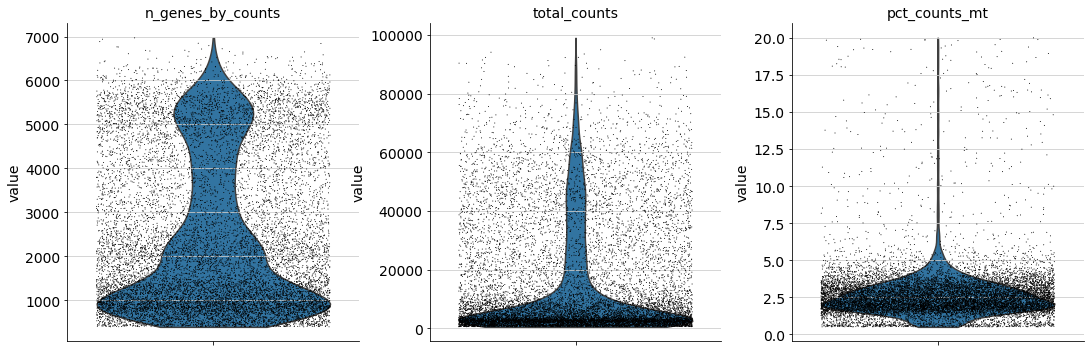

In [10]:
#Genete violing plot of number of genes in, total gene counts and percent of reads that are mitochondrial
sc.pl.violin(Combined, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

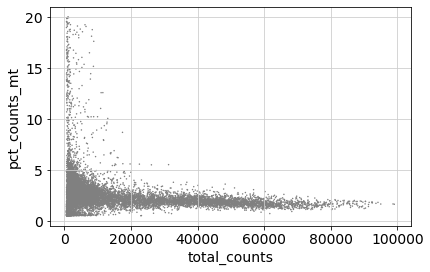

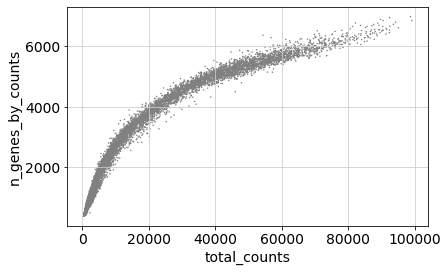

In [11]:
#QC plots
sc.pl.scatter(Combined, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(Combined, x='total_counts', y='n_genes_by_counts')

In [12]:
##Filter low count genes/cells
Combined = Combined[Combined.obs.n_genes_by_counts < 2500, :]
Combined = Combined[Combined.obs.pct_counts_mt < 5, :]


In [13]:
sc.pp.normalize_total(Combined)
sc.pp.normalize_per_cell(Combined)

/home/lcorrea/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [14]:
#Tansforming to log
sc.pp.log1p(Combined)

" In this step, the Day_Infection is filtered to keep only genes that are “informative” of the variability in the data. Thus, highly variable genes (HVGs) are often used (Brennecke et al, 2013). Depending on the task and the complexity of the Day_Infection, typically between 1,000 and 5,000 HVGs are selected for downstream analysis (see Fig EV1 and Day_Infection EV1). Preliminary results from Klein et al (2015) suggest that downstream analysis is robust to the exact choice of the number of HVGs. While varying the number of HVGs between 200 and 2,400, the authors reported similar low-dimensional representations in the PCA space. Based on this result, we prefer to err on the side of higher numbers of HVGs."-Luecken,Molecular Systems Biology,2019


As stated above, usually here is when people will filter non highly variable genes. However, the nature of this scRNA expeiremnt is different than the usual experiment. Generally, there is a study of multiple cell types, in this setting low variance genes are not of use as they likely don't contain information in varying cell states. However, we are interested in assesing pathways that are:
#1) Ubiquetously expressed
#2) Expect to change significnatly between some seet Tn VS Teff but not necessarely between Teff from Different days.
 
As such this  would lead to to removal of these genes from analysis before they are assesed that are of biological significant. 

Rather than keeping all genes, I have seen analysis were only genes in the top 25 Principle components are maintained. Will give thought on this approach for future versions of this analys.



In [15]:
sc.pp.regress_out(Combined, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:17)


"Count depths for identical cells can differ due to the variability inherent in each of these steps. Thus, when gene 
expression is compared between cells based on count data, any difference may have arisen solely due to sampling effects. 
Normalization addresses this issue by e.g. scaling count data to obtain correct relative gene expression abundances between 
cells."-Hafemeister,Genome Biology,2019

In [16]:
sc.pp.scale(Combined, max_value=10)

In [17]:
#Identifying ost variable genes
sc.tl.pca(Combined, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:09)


In [18]:
Combined.var_names

Index(['Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'X4732440D04Rik',
       'Pcmtd1', 'Rrs1', 'Vcpip1', 'Sgk3',
       ...
       'mt.Nd3', 'mt.Nd4l', 'mt.Nd4', 'mt.Nd5', 'mt.Nd6', 'mt.Cytb', 'Vamp7',
       'AC125149.3', 'AC149090.1', 'CAAA01118383.1'],
      dtype='object', length=9935)

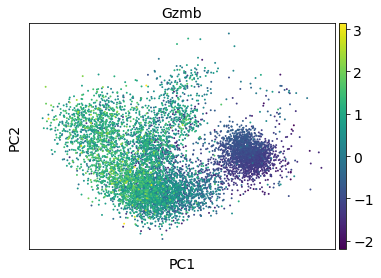

In [19]:
#PCA of the data colored by granzyme expression. This support the notion that PC1 is reallgy driven by Naive vs Effector 
#Differences. 
sc.pl.pca(Combined, color='Gzmb')

Next, Variance ratios by PCA componenet are calculated to identify components that are usefull for selecting genes that will allow for efficient and robust clusteirng of the data.

"Typically, PCA summarizes a Day_Infection via its top N principal components, where N can be determined by “elbow” heuristics (see Fig 4F) or the permutation-test-based jackstraw method (Chung & Storey, 2015; Macosko et al, 2015). The simple linearity of PCA has the advantage that distances in reduced dimensional space have a consistent interpretation in all regions of this space. Thus, we can correlate quantities of interest with principal components to assess their importance."-Luecken,Molecular Systems Biology,2019

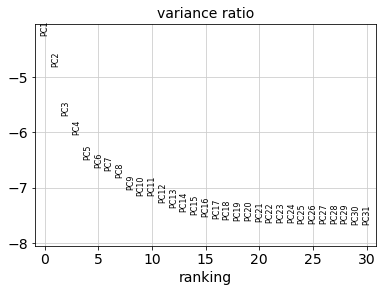

In [20]:

sc.pl.pca_variance_ratio(Combined, log=True)

In [21]:
Combined.write(results_file)

In [22]:
#Most of variance is in first 5 princeiple components with some chunk in the following 3.  As such I picked the first 8.
sc.pp.neighbors(Combined, n_neighbors=10, n_pcs=8)

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


When it comes to visualization there are several approaches. Bellow I have attached an exerp advocating for UMAP. This does not mean other methods are unacetable. 

"For visualization purposes, it is standard practice to use non-linear dimensionality reduction methods (Fig 4). The most common dimensionality reduction method for scRNA-seq visualization is the t-distributed stochastic neighbour embedding (t-SNE; van der Maaten & Hinton, 2008). t-SNE dimensions focus on capturing local similarity at the expense of global structure. Thus, these visualizations may exaggerate differences between cell populations and overlook potential connections between these populations. A further difficulty is the choice of its perplexity parameter, as t-SNE graphs may show strongly different numbers of clusters depending on its value (Wattenberg et al, 2016). Common alternatives to t-SNE are the Uniform Approximation and Projection method (UMAP; preprint: McInnes & Healy, 2018) or graph-based tools such as SPRING (Weinreb et al, 2018). UMAP and SPRING's force-directed layout algorithm ForceAtlas2 arguably represent the best approximation of the underlying topology (Wolf et al, 2019, Supplemental Note 4). What sets UMAP apart in this comparison is its speed and ability to scale to large numbers of cells (Becht et al, 2018). Thus, in the absence of particular biological questions, we regard UMAP as best practice for exploratory data visualization. Moreover, UMAP can also summarize data in more than two dimensions."-Luecken,Molecular Systems Biology,2019



In [23]:
sc.tl.umap(Combined)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


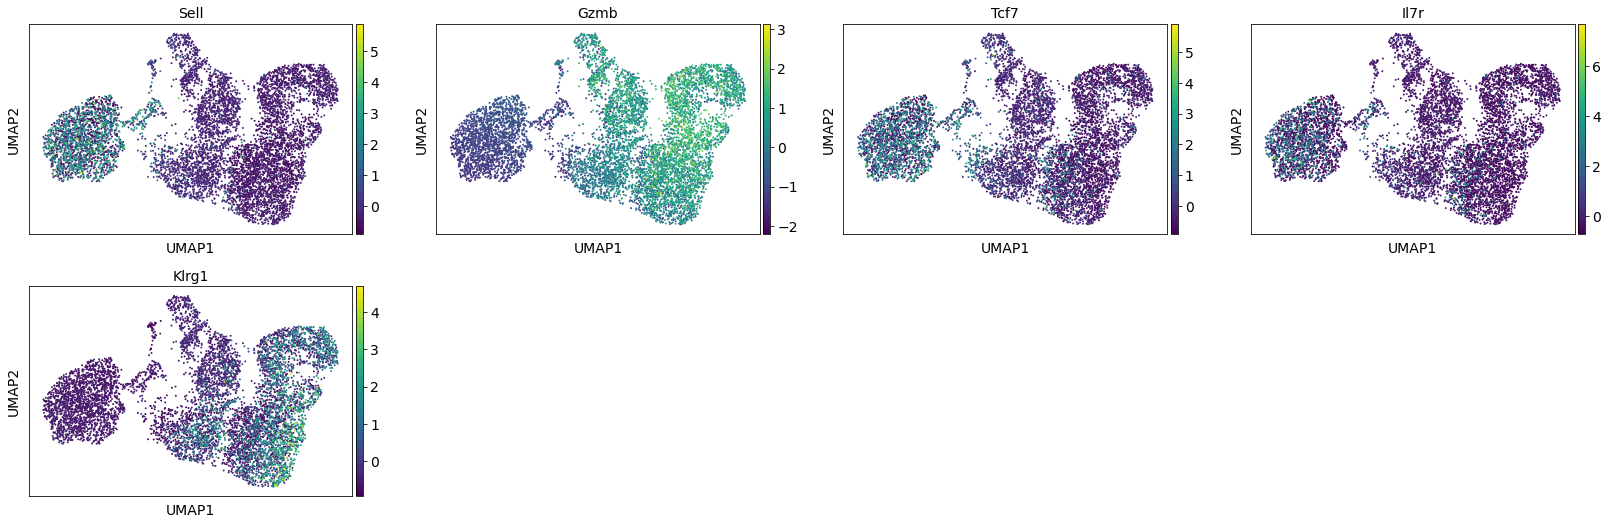

In [24]:
sc.pl.umap(Combined, color=['Sell', 'Gzmb', 'Tcf7',"Il7r","Klrg1"])

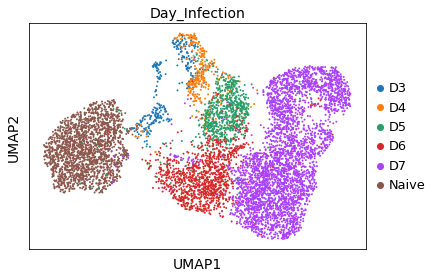

In [25]:
new_cluster_names = [
    'Naive', 'D3',
    'D4', 'D5',
    'D6', 'D7',
    'D7_2']
Combined.rename_categories('Day_Infection', new_cluster_names)


Combined.obs['Day_Infection'][Combined.obs['Day_Infection']=='D7_2']='D7'
Combined.obs['Day_Infection']=Combined.obs['Day_Infection'].astype('str').astype('category')
### Reorder and rename the Leiden
#Combined.obs['Day_Infection'].cat.rename_categories(np.arange(len(np.unique(Combined.obs['Day_Infection']))).astype('str'), inplace=True)

sc.pl.umap(Combined, color=['Day_Infection'])

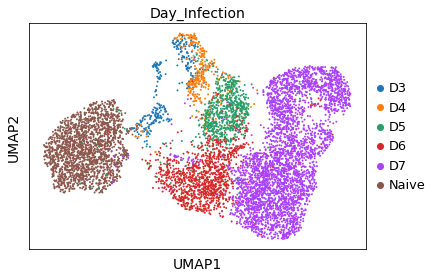

In [26]:
sc.pl.umap(Combined, color=['Day_Infection'])

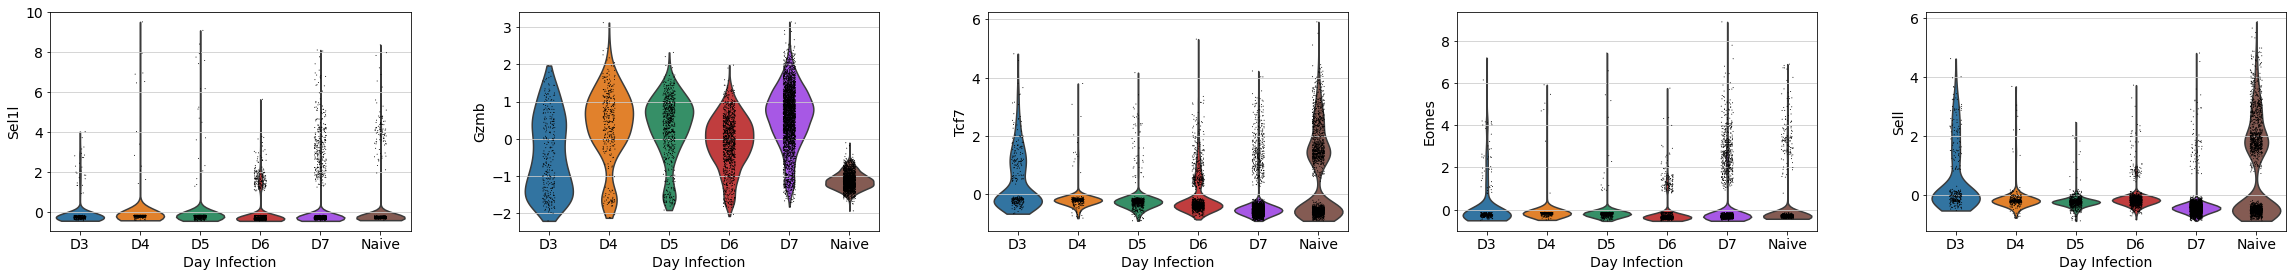

In [27]:
sc.pl.violin(Combined, ['Sel1l', 'Gzmb', 'Tcf7',"Eomes","Sell"], groupby='Day_Infection')

In [39]:
sc.tl.leiden(Combined)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [34]:
#This finilizes a more robust porcessing of the data 
Combined.write(results_file) 